@author: Pavlo Mospan

In [1]:
!pip install keras-tuner
!pip install yfinance

import numpy as np
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM,Dense,Dropout, Activation
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from kerastuner import HyperModel
from kerastuner.tuners import RandomSearch
from tensorflow.keras.models import load_model
import yfinance as yf
from datetime import datetime, date, timedelta
import pandas as pd
from numpy import concatenate

     |████████████████████████████████| 71kB 9.4MB/s 
  Created wheel for keras-tuner: filename=keras_tuner-1.0.2-cp36-none-any.whl size=78939 sha256=955ec75a42ed4580220e11fcb0c3b64fceea195b09dcf1e5bd96afb306ca937c
  Stored in directory: /root/.cache/pip/wheels/bb/a1/8a/7c3de0efb3707a1701b36ebbfdbc4e67aedf6d4943a1f463d6
  Created wheel for terminaltables: filename=terminaltables-3.1.0-cp36-none-any.whl size=15358 sha256=7960f7b462ca6da696ad850bbeabb2e6fadbe383912a9a8ae29650f47c1d4c99
  Stored in directory: /root/.cache/pip/wheels/30/6b/50/6c75775b681fb36cdfac7f19799888ef9d8813aff9e379663e
Successfully built keras-tuner terminaltables
     |████████████████████████████████| 5.5MB 18.0MB/s 
  Created wheel for yfinance: filename=yfinance-0.1.55-py2.py3-none-any.whl size=22616 sha256=8f8eab1c6c690e1909d9a28d1a26ab087ac9d0e01db409630d467ac4521c86ba
  Stored in directory: /root/.cache/pip/wheels/04/98/cc/2702a4242d60bdc14f48b4557c427ded1fe92aedf257d4565c
Successfully built yfinance
  Found 

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


## Data


In [2]:
today = datetime.today().strftime('%Y-%m-%d')
start_date = '2015-08-07'
idx = pd.date_range(start_date, today)

df_A = yf.download("BTC-USD", start=start_date, end=today)
df_A = df_A["Close"]
df_A = df_A.reindex(idx, fill_value=0, method="nearest")

# The S&P 500 - stock market index that measures the stock performance of 500 large companies listed on stock exchanges in the US. 
df_B = yf.download("%5EGSPC", start=start_date, end=today)
df_B = df_B["Close"]
df_B = df_B.reindex(idx, fill_value=0, method="nearest")

# US Dollar/USDX - Index - Cash
df_C = yf.download("DX-Y.NYB", start=start_date, end=today)
df_C = df_C["Close"]
df_C = df_C.reindex(idx, fill_value=0, method="nearest")

# Gold
df_D = yf.download("GC=F", start=start_date, end=today)
df_D = df_D["Close"]
df_D = df_D.reindex(idx, fill_value=0, method="nearest")

timeseries=  pd.concat([df_A, df_B, df_C, df_D], axis=1)

timeseries.columns=(["Close-btc", "Close-sp500", "Close-dxy", "Close-gold"])
timeseries

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


,Close-btc,Close-sp500,Close-dxy,Close-gold
2015-08-07,279.584991,2077.570068,97.559998,1094.099976
2015-08-08,260.997009,2077.570068,97.559998,1094.099976
2015-08-09,265.083008,2104.179932,97.160004,1104.199951
2015-08-10,264.470001,2104.179932,97.160004,1104.199951
2015-08-11,270.385986,2084.070068,97.290001,1107.599976
...,...,...,...,...
2021-01-22,36069.804688,3841.469971,90.239998,1855.699951
2021-01-23,32185.724609,3841.469971,90.239998,1855.699951
2021-01-24,32185.724609,3855.360107,90.389999,1854.900024
2021-01-25,32185.724609,3855.360107,90.389999,1854.900024


In [3]:
scl = MinMaxScaler()

timeseries[["Close-btc", "Close-sp500", "Close-dxy", "Close-gold"]] = scl.fit_transform(timeseries[["Close-btc", "Close-sp500", "Close-dxy", "Close-gold"]])

timeseries["Close-btc-output"] = timeseries["Close-btc"]
timeseries["Close-btc-output"] = timeseries["Close-btc-output"].shift(-1)
#timeseries.drop(timeseries.tail(1).index, inplace=True)
timeseries.loc[today, 'Close-btc-output']
timeseries

,Close-btc,Close-sp500,Close-dxy,Close-gold,Close-btc-output
2015-08-07,0.001702,0.122634,0.610204,0.043270,0.001244
2015-08-08,0.001244,0.122634,0.610204,0.043270,0.001345
2015-08-09,0.001345,0.135766,0.582994,0.053363,0.001330
2015-08-10,0.001330,0.135766,0.582994,0.053363,0.001476
2015-08-11,0.001476,0.125841,0.591837,0.056760,0.001377
...,...,...,...,...,...
2021-01-22,0.883515,0.993145,0.112245,0.804337,0.787817
2021-01-23,0.787817,0.993145,0.112245,0.804337,0.787817
2021-01-24,0.787817,1.000000,0.122449,0.803538,0.787817
2021-01-25,0.787817,1.000000,0.122449,0.803538,0.787817


#### Filling today's **Close-btc-output** value with yesterday value. This is needed for later proper prediction

In [4]:
yesterday = date.today() - timedelta(days=1)
yesterday = yesterday.strftime('%Y-%m-%d')

timeseries.loc[today, 'Close-btc-output'] = timeseries.loc[yesterday, 'Close-btc-output']
timeseries
print(timeseries)
array = timeseries.values
print(array)

            Close-btc  Close-sp500  Close-dxy  Close-gold  Close-btc-output
2015-08-07   0.001702     0.122634   0.610204    0.043270          0.001244
2015-08-08   0.001244     0.122634   0.610204    0.043270          0.001345
2015-08-09   0.001345     0.135766   0.582994    0.053363          0.001330
2015-08-10   0.001330     0.135766   0.582994    0.053363          0.001476
2015-08-11   0.001476     0.125841   0.591837    0.056760          0.001377
...               ...          ...        ...         ...               ...
2021-01-22   0.883515     0.993145   0.112245    0.804337          0.787817
2021-01-23   0.787817     0.993145   0.112245    0.804337          0.787817
2021-01-24   0.787817     1.000000   0.122449    0.803538          0.787817
2021-01-25   0.787817     1.000000   0.122449    0.803538          0.787817
2021-01-26   0.787817     1.000000   0.122449    0.803538          0.787817

[2000 rows x 5 columns]
[[0.00170226 0.12263364 0.61020397 0.04326964 0.00124429]
 [0.0

In [5]:
#number of days to take in a row before Y
X_quantity = 3  
mod = len(array) % X_quantity

# how many predictions to make
times = 7

# deleting first-mod values to have /mod-zero array
for i_ in range(mod):
  array = np.delete(array, 0, 0)

# for splitting into train/test
division = X_quantity * times
split = len(array) - division
print('Division: ', division, 'Split is on: ', split)

predict = array[split:]
train = array[:split]

Division:  21 Split is on:  1977


In [6]:
def get_X_values(values):
  x = []
  ready_X = []
  COUNT = 1
  for i_ in values:
    x.extend(i_)
    if COUNT % X_quantity == 0:
      ready_X.append(x)
      x = []

    COUNT += 1

  ready_X = np.array(ready_X)
  return ready_X

def get_Y_targets(targets):
  ready_Y = []
  for i_ in range(int(len(targets) / X_quantity)):
    i_ += 1
    ready_Y.append(targets[i_ * X_quantity -1])

  ready_Y = np.array(ready_Y)
  return ready_Y

In [7]:
predict_values = predict[:, :-1]
predict_target = predict[:, -1]

print('predict_values.shape: {} | predict_target.shape: {}'.format(predict_values.shape, predict_target.shape))

predict_X = get_X_values(predict_values)
print('\n predict_X type: {} \n predict_X.shape: {} \n predict_X: \n{}'.format(type(predict_X), predict_X.shape, predict_X))

predict_Y = get_Y_targets(predict_target)
print('\nPred Y: {}'.format(predict_Y))

predict_values.shape: (21, 4) | predict_target.shape: (21,)

 predict_X type: <class 'numpy.ndarray'> 
 predict_X.shape: (7, 12) 
 predict_X: 
[[0.90210573 0.9470852  0.06394572 0.85550117 0.96485174 0.97454939
  0.08435409 0.86089741 1.         0.98485887 0.10068047 0.78275204]
 [0.98661983 0.98485887 0.10068047 0.78275204 0.93985362 0.97248653
  0.13265333 0.7982412  0.87111789 0.97248653 0.13265333 0.7982412 ]
 [0.83061993 0.9732662  0.09932015 0.79154593 0.9142277  0.97753518
  0.11768727 0.8022384  0.96032531 0.97047789 0.11224497 0.79894078]
 [0.90213046 0.95700984 0.14897971 0.77795547 0.88618386 0.95700984
  0.14897971 0.77795547 0.87665218 0.97214097 0.12993218 0.78814829]
 [0.89731876 0.97214097 0.12993218 0.78814829 0.88351464 0.97214097
  0.12993218 0.78814829 0.88351464 0.99826776 0.12789145 0.81452984]
 [0.88351464 0.99886983 0.10476193 0.81393029 0.88351464 0.99314501
  0.11224497 0.80433691 0.78781727 0.99314501 0.11224497 0.80433691]
 [0.78781727 1.         0.12244915 

In [8]:
train_values = train[:, :-1]
train_target = train[:, -1]

print('train_values.shape: {} | train_target.shape : {}'.format(train_values.shape, train_target.shape))

train_X = get_X_values(train_values)
print('\n type of train_X: {} \n train_X.shape: {} \n train_X: \n {}'.format(type(train_X), train_X.shape, train_X))

train_Y = get_Y_targets(train_target)
print('\n len(train_Y) : {} '.format(len(train_Y)))

train_values.shape: (1977, 4) | train_target.shape : (1977,)

 type of train_X: <class 'numpy.ndarray'> 
 train_X.shape: (659, 12) 
 train_X: 
 [[0.00134496 0.13576601 0.58299351 ... 0.12584149 0.59183686 0.0567602 ]
 [0.00137682 0.12681864 0.52176894 ... 0.12952803 0.5428572  0.06205654]
 [0.00125794 0.12952803 0.5428572  ... 0.1349073  0.559864   0.0677525 ]
 ...
 [0.66213906 0.94077818 0.11904758 ... 0.93913968 0.07074834 0.83961226]
 [0.70936863 0.95099886 0.09183712 ... 0.92364817 0.08775514 0.89327465]
 [0.8025091  0.92364817 0.08775514 ... 0.9365833  0.05782353 0.90126906]]

 len(train_Y) : 659 


In [9]:
#splitting into Train and Test

# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
predict_X = predict_X.reshape((predict_X.shape[0], 1, predict_X.shape[1]))

X_train, X_validate, Y_train, Y_validate = train_test_split(train_X, train_Y, test_size=0.20, random_state=42)

print('X_train.shape: {} |  Y_train: {}'.format( X_train.shape, Y_train.shape))

X_train.shape: (527, 1, 12) |  Y_train: (527,)


In [10]:
forward_days=1

predict_X, predict_X.shape

(array([[[0.90210573, 0.9470852 , 0.06394572, 0.85550117, 0.96485174,
          0.97454939, 0.08435409, 0.86089741, 1.        , 0.98485887,
          0.10068047, 0.78275204]],
 
        [[0.98661983, 0.98485887, 0.10068047, 0.78275204, 0.93985362,
          0.97248653, 0.13265333, 0.7982412 , 0.87111789, 0.97248653,
          0.13265333, 0.7982412 ]],
 
        [[0.83061993, 0.9732662 , 0.09932015, 0.79154593, 0.9142277 ,
          0.97753518, 0.11768727, 0.8022384 , 0.96032531, 0.97047789,
          0.11224497, 0.79894078]],
 
        [[0.90213046, 0.95700984, 0.14897971, 0.77795547, 0.88618386,
          0.95700984, 0.14897971, 0.77795547, 0.87665218, 0.97214097,
          0.12993218, 0.78814829]],
 
        [[0.89731876, 0.97214097, 0.12993218, 0.78814829, 0.88351464,
          0.97214097, 0.12993218, 0.78814829, 0.88351464, 0.99826776,
          0.12789145, 0.81452984]],
 
        [[0.88351464, 0.99886983, 0.10476193, 0.81393029, 0.88351464,
          0.99314501, 0.11224497, 0.8043

#### Training The Model

In [11]:
#Training the model

class MyHyperModel(HyperModel):

    def __init__(self, num_classes):
        self.num_classes = num_classes

    def build(self, hp):
        
        # Specify model
        model = Sequential()
        NUM_NEURONS_FirstLayer = hp.Choice('NUM_NEURONS_FirstLayer',values=[80, 90, 100, 120])

        model.add(LSTM(NUM_NEURONS_FirstLayer,input_shape=(X_train.shape[1],X_train.shape[2]), return_sequences=True))

        model.add(Dropout(hp.Float('dropout_1', 0, 0.4, step=0.1, default=0)))

        
        NUM_NEURONS_SecondLayer = hp.Choice('NUM_NEURONS_SecondLayer',values=[30, 40, 50, 60, 70])
        model.add(LSTM(NUM_NEURONS_SecondLayer,input_shape=(NUM_NEURONS_FirstLayer,1)))

        model.add(Dropout(hp.Float('dropout_2', 0, 0.4, step=0.1, default=0)))

        # Output layer
        model.add(Dense(forward_days, activation='linear'))

        # Compile the constructed model and return it
        model.compile(
            optimizer=Adam(
                hp.Choice('learning_rate',
                          values=[0.01, 0.001, 0.0001])),
            loss='mean_squared_error')

        return model

In [12]:
hypermodel = MyHyperModel(num_classes=1)    

# Construct the RandomSearch tuner
random_tuner = RandomSearch(
    hypermodel,
    objective='val_loss',
    max_trials=100,
    executions_per_trial = 1,
    seed=10, 
    project_name='lstm-kerastuner-multi',
    directory="/content")

# Search for the best parameters of the neural network using the contructed random search tuner
random_tuner.search(X_train, Y_train,
             epochs=100,
             validation_data=(X_validate, Y_validate))

#get the best model

random_params = random_tuner.get_best_hyperparameters()[0]
best_model = random_tuner.get_best_models(1)[0]

Trial 100 Complete [00h 00m 15s]
val_loss: 0.0001041246359818615

Best val_loss So Far: 8.042524132179096e-05
Total elapsed time: 00h 25m 24s
INFO:tensorflow:Oracle triggered exit


In [13]:
best_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 1, 90)             37080     
_________________________________________________________________
dropout (Dropout)            (None, 1, 90)             0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 40)                20960     
_________________________________________________________________
dropout_1 (Dropout)          (None, 40)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 41        
Total params: 58,081
Trainable params: 58,081
Non-trainable params: 0
_________________________________________________________________


#### Saving the model

In [14]:
#Saving the model

file_name = 'LSTM_MULTI-3.h5'
best_model.save(file_name)
print("Saved model `{}` to disk".format(file_name))

Saved model `LSTM_MULTI-3.h5` to disk


#### Loading model fron **/content** or **gdrive** and predicting

In [ ]:
# Loading Model

file_name = '/content/gdrive/MyDrive/ColabData/LSTM_MULTI-7.h5'
#file_name = '/content/LSTM_MULTI.h5'
model = tf.keras.models.load_model(file_name)
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 1, 100)            51600     
_________________________________________________________________
dropout (Dropout)            (None, 1, 100)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 70)                47880     
_________________________________________________________________
dropout_1 (Dropout)          (None, 70)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 71        
Total params: 99,551
Trainable params: 99,551
Non-trainable params: 0
_________________________________________________________________


In [15]:
#yhat = model.predict(predict_X)       
yhat = best_model.predict(predict_X) 
yhat, yhat.shape                      

(array([[1.0114018 ],
        [0.93943006],
        [0.9603549 ],
        [0.91512686],
        [0.9190782 ],
        [0.85542196],
        [0.8125335 ]], dtype=float32), (7, 1))

In [17]:
def get_array(g):
  g = np.insert(g, [1], .4, axis = 1)
  g = np.insert(g, [2], .4, axis = 1)
  g = np.insert(g, [3], .4, axis = 1)

  array_ = scl.inverse_transform(g)
  array_ready = []
  for i in range(len(array_[:, :1])):
    array_ready.append(array_[i,:1][0])

  return array_ready

In [20]:
pred = get_array(yhat)
print("PRED: ", pred)

true = get_array(predict_Y.reshape(-1,1))
print('TRUE: ', true)

PRED:  [41260.37, 38339.25, 39188.53, 37352.855, 37513.227, 34929.605, 33188.887]
TRUE:  [40254.546875, 33922.9609375, 36825.3671875, 36630.07421875, 36069.8046875, 32185.724609375, 32185.724609375]


#DELETE LAST REAL VALUE - 

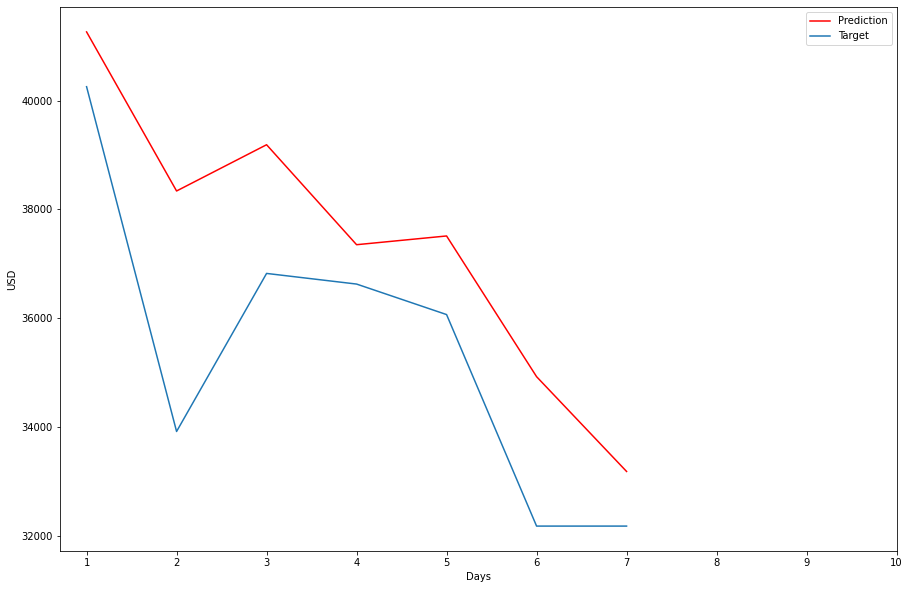

In [22]:
plt.figure(figsize = (15,10))
plt.plot(pred, color='r', label='Prediction') 
plt.plot(true, label='Target')
plt.xticks(np.arange(0, 10, 1), np.arange(1, 21, 1))
plt.xlabel('Days')
plt.ylabel('USD')
plt.legend(loc='best')
plt.show()